In [1]:
# import craft functions
from craft_text_detector import (
    read_image,
    load_craftnet_model,
    load_refinenet_model,
    get_prediction
)

import matplotlib.pyplot as plt
import cv2
import numpy as np
from typing import Dict
from PIL import Image
from pathlib import Path

In [2]:
# load models
refine_net = load_refinenet_model(cuda=False)
craft_net = load_craftnet_model(cuda=False)

/home/sge/Documents/Sergio's OV [Debian]/Esade MiBA/TFM/albcovis-project/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sge/Documents/Sergio's OV [Debian]/Esade MiBA/TFM/albcovis-project/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [3]:
def plot_craft_detections(img_path: str, result: Dict, show=True, save_path=None):
    """
    Plot detected text boxes on the original image.

    Args:
        result (dict): Output from `get_prediction()`
        show (bool): Whether to display the plot
        save_path (str): If provided, saves the result to this path
    """
    image = Image.open(img_path)
    image = np.array(image)
    boxes = result["boxes"]

    img_copy = image.copy()
    for box in boxes:
        box = box.astype(np.int32).reshape((-1, 1, 2))
        cv2.polylines(img_copy, [box], isClosed=True, color=(0, 255, 0), thickness=2)

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
    plt.title("CRAFT: Detected Text Regions")
    plt.axis("off")

    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    if show:
        plt.show()


def plot_craft_with_heatmap(img_path: str, result: Dict, heatmap_type="text_score_heatmap", alpha=0.4, show=True, save_path=None):
    """
    Plot text detections with heatmap overlaid on the original image.

    Args:
        result (dict): Output from `get_prediction()`
        heatmap_type (str): 'text_score_heatmap' or 'link_score_heatmap'
        alpha (float): Transparency of heatmap overlay
        show (bool): Whether to display the plot
        save_path (str): If provided, saves the result to this path
    """
    image = Image.open(img_path)
    image = np.array(image)
    boxes = result["boxes"]
    heatmap = result["heatmaps"][heatmap_type]

    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

    overlay = cv2.addWeighted(image, 1 - alpha, heatmap_resized, alpha, 0)

    # Draw boxes
    for box in boxes:
        box = box.astype(np.int32).reshape((-1, 1, 2))
        cv2.polylines(overlay, [box], isClosed=True, color=(0, 255, 0), thickness=2)

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(f"CRAFT Detection with {heatmap_type}")
    plt.axis("off")

    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    if show:
        plt.show()


In [4]:
# set image path and export folder directory
img_path = '../data/source/images/4924862361-large.jpg' # can be filepath, PIL image or numpy array

# read image
image = read_image(img_path)

# perform prediction
prediction_result = get_prediction(
    image=image,
    craft_net=craft_net,
    refine_net=refine_net,
    text_threshold=0.5,
    link_threshold=0.1,
    low_text=0.4,
    cuda=False,
    long_size=500
)

prediction_result

{'boxes': array([[[241.67674, 286.10052],
         [367.93405, 283.1643 ],
         [368.4151 , 303.85077],
         [242.1578 , 306.787  ]],
 
        [[416.2195 , 438.02438],
         [475.48782, 444.60977],
         [473.73172, 460.41464],
         [414.4634 , 453.82925]]], dtype=float32),
 'boxes_as_ratios': array([[[0.48335349, 0.57220105],
         [0.7358681 , 0.56632861],
         [0.7368302 , 0.60770154],
         [0.48431561, 0.61357397]],
 
        [[0.83243903, 0.87604877],
         [0.95097565, 0.88921954],
         [0.94746344, 0.92082928],
         [0.82892682, 0.90765851]]]),
 'polys': array([array([[241.67674, 286.10052],
               [367.93405, 283.1643 ],
               [368.4151 , 303.85077],
               [242.1578 , 306.787  ]], dtype=float32),
        array([[416.2195 , 438.02438],
               [475.48782, 444.60977],
               [473.73172, 460.41464],
               [414.4634 , 453.82925]], dtype=float32)], dtype=object),
 'polys_as_ratios': array([[[0

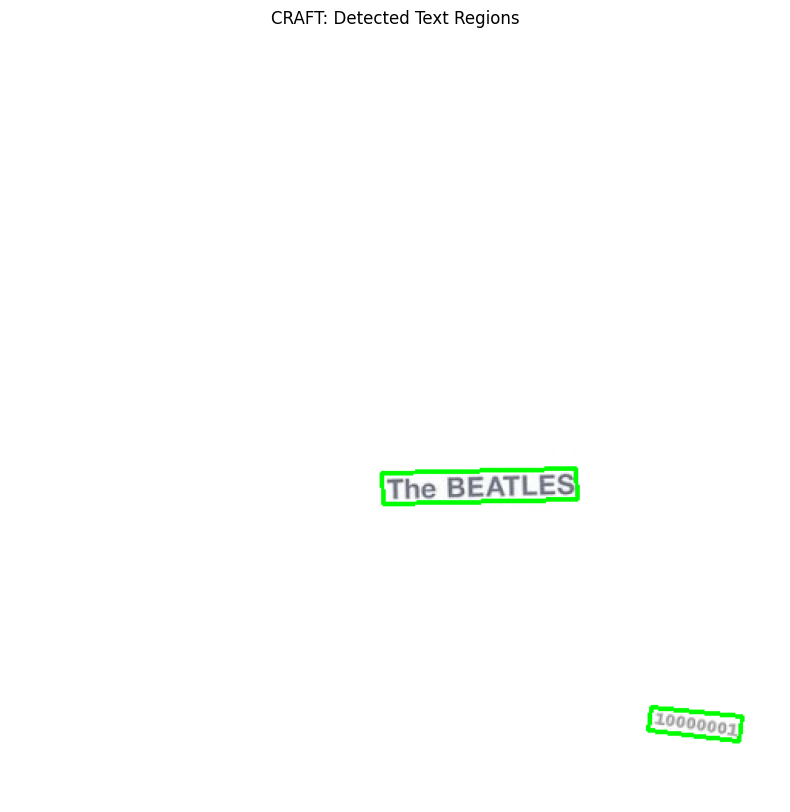

In [5]:
plot_craft_detections(img_path, prediction_result)

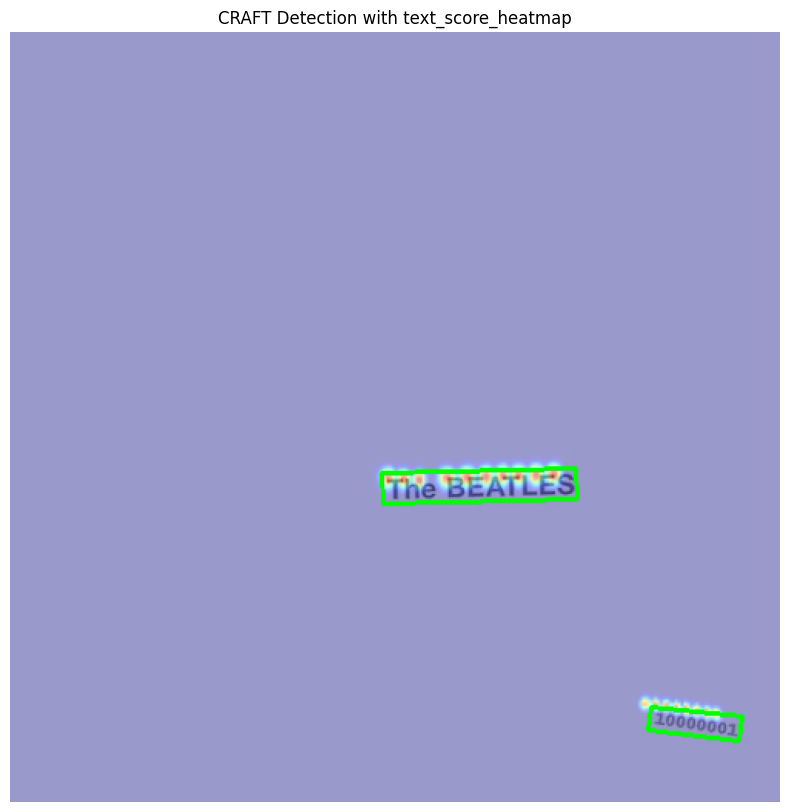

In [6]:
plot_craft_with_heatmap(img_path, prediction_result)

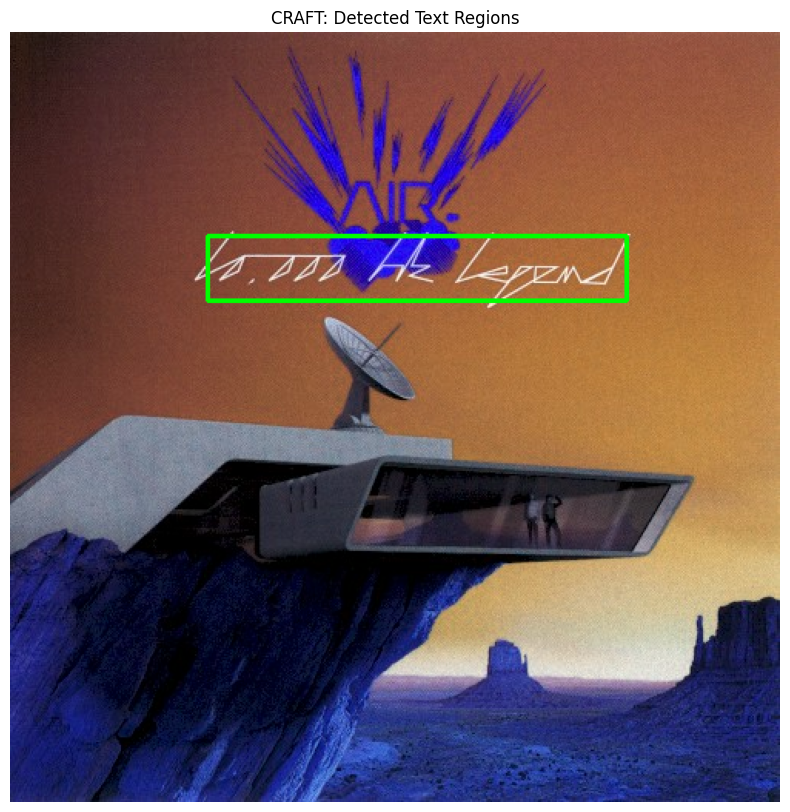

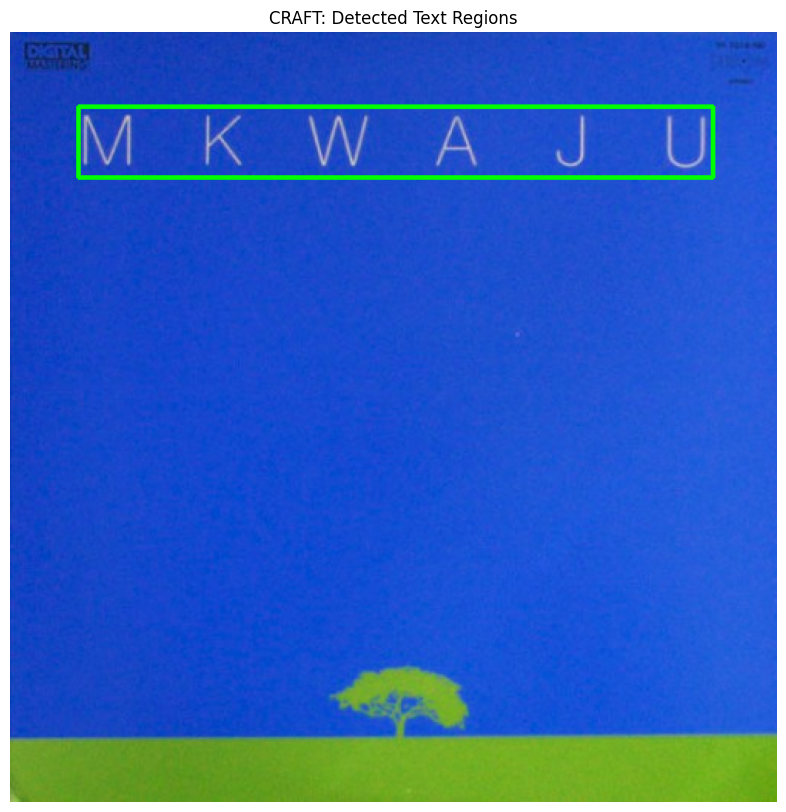

In [7]:
dir = Path("../data/source/images")
imgs_filenames = [
    "40654268451-px_500.jpg", # 10000Hz Legend
    "14688551481-large.jpg", # MKWAJU
    "9845751214-large.jpg", # Gotan Project
    "22280981189-px_500.jpg", # Dick's Picks Volume Four
    "11446625684-large.jpg", # Carnaval
    "24818281700-px_500.jpg", # Tiger Army Retrofuture
    "39341710398-px_500.jpg", # Xerrox
    "3880053972-px_500.jpg", # Unknown Pleasures
    "24961543145-px_500.jpg", # Hats
    "23776122656-px_500.jpg", # Tre
    "1766939079-large.jpg", # Richest man in babylon
    "17519297659-px_500.jpg", # Amor amarillo
    "4924862361-large.jpg", # The White Album
    "30944412549-px_500.jpg" # Donda
    ]

for filename in imgs_filenames[:2]:
    path = dir / filename
    image = Image.open(path)
    image = np.array(image)
    # image = read_image(str(path))

    # perform prediction
    prediction_result = get_prediction(
        image=image,
        craft_net=craft_net,
        refine_net=refine_net,
        text_threshold=0.5,
        link_threshold=0.1, #0.4
        low_text=0.4,
        cuda=False,
        long_size=500
    )

    plot_craft_detections(path, prediction_result)

In [8]:
import pandas as pd

df = pd.read_csv("../data/processed/craft_grid/metrics_summary.csv")
c = "AP@0.10"
df[["config","mean_time", c]].sort_values(c, ascending=False).head(15)

,config,mean_time,AP@0.10
35,text=0.5_link=0.1_low=0.4_size=500,1.237927,0.495030
23,text=0.7_link=0.1_low=0.4_size=500,1.465603,0.483543
21,text=0.7_link=0.1_low=0.4_size=1280,8.783884,0.480443
18,text=0.7_link=0.2_low=0.4_size=1280,10.862677,0.473058
6,text=0.9_link=0.2_low=0.4_size=1280,9.067481,0.471740
9,text=0.9_link=0.1_low=0.4_size=1280,9.062258,0.465117
22,text=0.7_link=0.1_low=0.4_size=800,3.521894,0.464209
34,text=0.5_link=0.1_low=0.4_size=800,3.067011,0.463204
47,text=0.3_link=0.1_low=0.4_size=500,1.317974,0.458086
30,text=0.5_link=0.2_low=0.4_size=1280,9.363951,0.448816


In [9]:
import pandas as pd

df = pd.read_csv("../data/processed/craft_grid/metrics_summary.csv")
c = "AR@0.10"
df[["config","mean_time", c]].sort_values(c, ascending=False).head(15)

,config,mean_time,AR@0.10
35,text=0.5_link=0.1_low=0.4_size=500,1.237927,0.532143
47,text=0.3_link=0.1_low=0.4_size=500,1.317974,0.530357
42,text=0.3_link=0.2_low=0.4_size=1280,9.317897,0.523214
30,text=0.5_link=0.2_low=0.4_size=1280,9.363951,0.523214
33,text=0.5_link=0.1_low=0.4_size=1280,8.284301,0.519643
45,text=0.3_link=0.1_low=0.4_size=1280,8.564361,0.517857
18,text=0.7_link=0.2_low=0.4_size=1280,10.862677,0.516071
21,text=0.7_link=0.1_low=0.4_size=1280,8.783884,0.516071
23,text=0.7_link=0.1_low=0.4_size=500,1.465603,0.508929
34,text=0.5_link=0.1_low=0.4_size=800,3.067011,0.505357


In [4]:
import os
import json
from shapely.geometry import Polygon

# Folder containing detection JSONs
FOLDER = "../data/processed/craft_grid/"

# Function to check if segmentation differs from bbox (as polygon)
def is_segmentation_different(bbox, segmentation):
    x, y, w, h = bbox
    bbox_poly = Polygon([
        (x, y),
        (x + w, y),
        (x + w, y + h),
        (x, y + h)
    ])
    seg_points = segmentation[0]  # segmentation is a list of list
    seg_poly = Polygon([(seg_points[i], seg_points[i+1]) for i in range(0, len(seg_points), 2)])
    return not bbox_poly.equals_exact(seg_poly, tolerance=1e-2)

# Loop through all detection files
different_cases = []

for fname in os.listdir(FOLDER):
    if not fname.endswith(".json"):
        continue
    path = os.path.join(FOLDER, fname)
    with open(path, "r") as f:
        detections = json.load(f)

    for det in detections:
        bbox = det["bbox"]
        segmentation = det["segmentation"]
        if is_segmentation_different(bbox, segmentation):
            different_cases.append({
                "file": fname,
                "image_id": det["image_id"],
                "bbox": bbox,
                "segmentation": segmentation
            })

# Print summary
print(f"Total differing cases found: {len(different_cases)}")
import json
for case in different_cases[:5]:  # show first 5 examples
    print(json.dumps(case, indent=4))


Total differing cases found: 4344
{
    "file": "detections_text=0.7_link=0.2_low=0.4_size=500.json",
    "image_id": 10046582074,
    "bbox": [
        330.8218078613281,
        4.8642730712890625,
        168.77020263671875,
        98.54872131347656
    ],
    "segmentation": [
        [
            330.8218078613281,
            8.268951416015625,
            497.6502990722656,
            4.8642730712890625,
            499.5920104980469,
            100.00831604003906,
            332.7635192871094,
            103.41299438476562
        ]
    ]
}
{
    "file": "detections_text=0.7_link=0.2_low=0.4_size=500.json",
    "image_id": 10046582074,
    "bbox": [
        10.547445297241211,
        291.3620300292969,
        108.79854011535645,
        67.33282470703125
    ],
    "segmentation": [
        [
            10.547445297241211,
            294.2554626464844,
            117.60438537597656,
            291.3620300292969,
            119.34598541259766,
            355.801422

# Test service function

In [10]:
from albcovis.services.text_detection import detect_text

path = '../data/source/images/4924862361-large.jpg' # can be filepath, PIL image or numpy array

texts = detect_text(path)

/home/sge/Documents/Sergio's OV [Debian]/Esade MiBA/TFM/albcovis-project/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sge/Documents/Sergio's OV [Debian]/Esade MiBA/TFM/albcovis-project/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [14]:
print(texts)

{'n_texts': 2, 'mean_area': 2180.1260375976562, 'largest_text': {'bbox': [241.67674255371094, 283.164306640625, 126.73835754394531, 23.6226806640625], 'segmentation': [[241.67674255371094, 283.164306640625, 368.41510009765625, 283.164306640625, 368.41510009765625, 306.7869873046875, 241.67674255371094, 306.7869873046875]], 'area': 2993.899658203125, 'relative_size': 0.011975598521530628}, 'average_relative_size': 0.01744100830078125, 'texts': [{'bbox': [241.67674255371094, 283.164306640625, 126.73835754394531, 23.6226806640625], 'segmentation': [[241.67674255371094, 283.164306640625, 368.41510009765625, 283.164306640625, 368.41510009765625, 306.7869873046875, 241.67674255371094, 306.7869873046875]], 'area': 2993.899658203125, 'relative_size': 0.011975598521530628}, {'bbox': [414.4634094238281, 438.0243835449219, 61.0244140625, 22.3902587890625], 'segmentation': [[414.4634094238281, 438.0243835449219, 475.4878234863281, 438.0243835449219, 475.4878234863281, 460.4146423339844, 414.463409

In [15]:
import json

print(json.dumps(texts, indent=4))


{
    "n_texts": 2,
    "mean_area": 2180.1260375976562,
    "largest_text": {
        "bbox": [
            241.67674255371094,
            283.164306640625,
            126.73835754394531,
            23.6226806640625
        ],
        "segmentation": [
            [
                241.67674255371094,
                283.164306640625,
                368.41510009765625,
                283.164306640625,
                368.41510009765625,
                306.7869873046875,
                241.67674255371094,
                306.7869873046875
            ]
        ],
        "area": 2993.899658203125,
        "relative_size": 0.011975598521530628
    },
    "average_relative_size": 0.01744100830078125,
    "texts": [
        {
            "bbox": [
                241.67674255371094,
                283.164306640625,
                126.73835754394531,
                23.6226806640625
            ],
            "segmentation": [
                [
                    241.676742553710

In [12]:
type(texts)

dict

In [1]:
from albcovis.services.text_detection import detect_text

path = '../data/source/images/30944412549-px_500.jpg' # can be filepath, PIL image or numpy array

texts = detect_text(path)

/home/sge/Documents/Sergio's OV [Debian]/Esade MiBA/TFM/albcovis-project/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sge/Documents/Sergio's OV [Debian]/Esade MiBA/TFM/albcovis-project/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [2]:
import json

print(json.dumps(texts, indent=4))


{
    "n_texts": 0,
    "mean_area": 0.0,
    "largest_text": null,
    "average_relative_size": 0.0,
    "texts": []
}
